In [78]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy import stats , optimize # Stats contains the ChiSquare function and its integral
from iminuit import Minuit

In [79]:
def error_mean(data: list, n: int) -> float:
    ''' 

    This function calculates the error on the mean. Suitable for when we have several data points without errors, e.g. the periods.

    Arguments:
        data (list / numpy.array): input data
        n (int): number of data points
    
    Returns:
        (float / np.float): error on the mean

    '''
    return np.std(data)/np.sqrt(n)

def error_mean_measured(data: list, n: int, error: float) -> float:
    '''
    This function calculates the total error of a quanitity with several measurements with the same error, e.g. the laser lengths. 
      
    Arguments:
        data (list / np.array): input data
        n (int): number of data samples
        error (float): error of all the measurements (all equal)
        
        
    Returns:
        (float / np.float): error as sum of error of the mean and error propagation
        
    '''
    return np.sqrt((error_mean(data,n)**2 + error**2))

def weighted_mean_err(data: list, err: list) -> tuple[float, float]:
    ''' 

    This function calculates the weighted mean and weighted mean error, suitable for instances where each measurement has different error, e.g. the tape lengths

    Arguments:
        data (list / np.array): input data
        err (list / np.array): error of each data point

    Returns
        wmean (float / np.float): weighted mean
        wmean_err (float / np.float): weighted mean error

    '''
    weights = 1 / err**2  
    wmean = np.sum(weights * data) / np.sum(weights)

    wmean_err = np.sqrt(1 / np.sum(weights))
    return wmean, wmean_err

def fit_function(x, alpha0, alpha1):
    ''' 
    Function to be fit in the chi2 fitting method.

    Arguments:
        x : independent variable
        alpha0 : offset
        alpha1 : slope

    '''

    return alpha0 + alpha1 * x


def find_fit(x, data, err, fit_function, params):
    ''' 

    This function finds the fitting parameters according to the fit_function() and the chisquare method.

    Arguments:
        data (list / np.array): input data
        err (list / np.array): error on the data points
    
    Returns:
        alpha0_fit (float / np.float): calculated offset
        sigma_alpha0_fit (float / np.float): error on the offset
        alpha1_fit (float / np.float): calculated slope
        sigma_alpha1_fit (float / np.float): error on the slope
        res (list / np.array): residuals
        chi2 (float / np.float): chi2 value
    
    '''
    
    y = np.array(data)
    sy = np.array(err)

    p1, pcov = optimize.curve_fit(fit_function, x, y, p0=params, sigma=sy)
    alpha0_fit, alpha1_fit = p1

    sigma_p1 = np.sqrt(np.diag(pcov))
    sigma_alpha0_fit, sigma_alpha1_fit = sigma_p1

    chi2 = np.sum(((fit_function(x, alpha0_fit, alpha1_fit) - y) / sy) ** 2)

    y_fit = fit_function(x, alpha0_fit, alpha1_fit)
    res = y - y_fit

    return alpha0_fit, sigma_alpha0_fit, alpha1_fit, sigma_alpha1_fit, res, chi2



def plot_fit(x, data, err, fit_function, params0):

    offset, offset_err, period, period_err, res, chi2 = find_fit(x, data, err, fit_function, params0)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), gridspec_kw={'height_ratios':[4,1]}, sharex=True)
    ax[0].errorbar(x, data, yerr=err, color='k', fmt='o')
    ax[0].plot(x,fit_function(x, offset, period), color = 'red')
    ax[0].text(0.1,211,'Result of the fit: \n'r'Offset = %.2f $\pm$ %.2f s '%(offset, offset_err), fontfamily='serif', fontsize=20)
    ax[0].text(0.1, 201, r'Period = %.3f $\pm$ %.3f s'%( period, period_err), fontfamily='serif', fontsize=20, color = 'red')
    ax[0].minorticks_on()
    ax[0].grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)
    ax[0].grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
    ax[0].set_xlabel('Measurement number', fontsize=18, loc='right')
    ax[0].set_ylabel('Time elapsed (s)', fontsize=18, loc = 'top')
    ax[1].scatter(x,res)

    plt.xticks()
    plt.yticks()
    plt.grid()
    
    plt.show()

    return offset, offset_err, period, period_err, res, chi2



# First method: calculate means and err of the mean before summing/doing operations

The first question to answer is how to calculate the most precise value of the period and the uncertainty of each one of the times. Since there are no given values to each error of the measurement, we can only account for the statistical uncertainty. This can be approximated with the standard error of the mean 

\begin{equation}
    \sigma_{\bar x} = \frac{\sigma_x}{\sqrt{N}}
\end{equation} 
with the previously computed standard deviation.

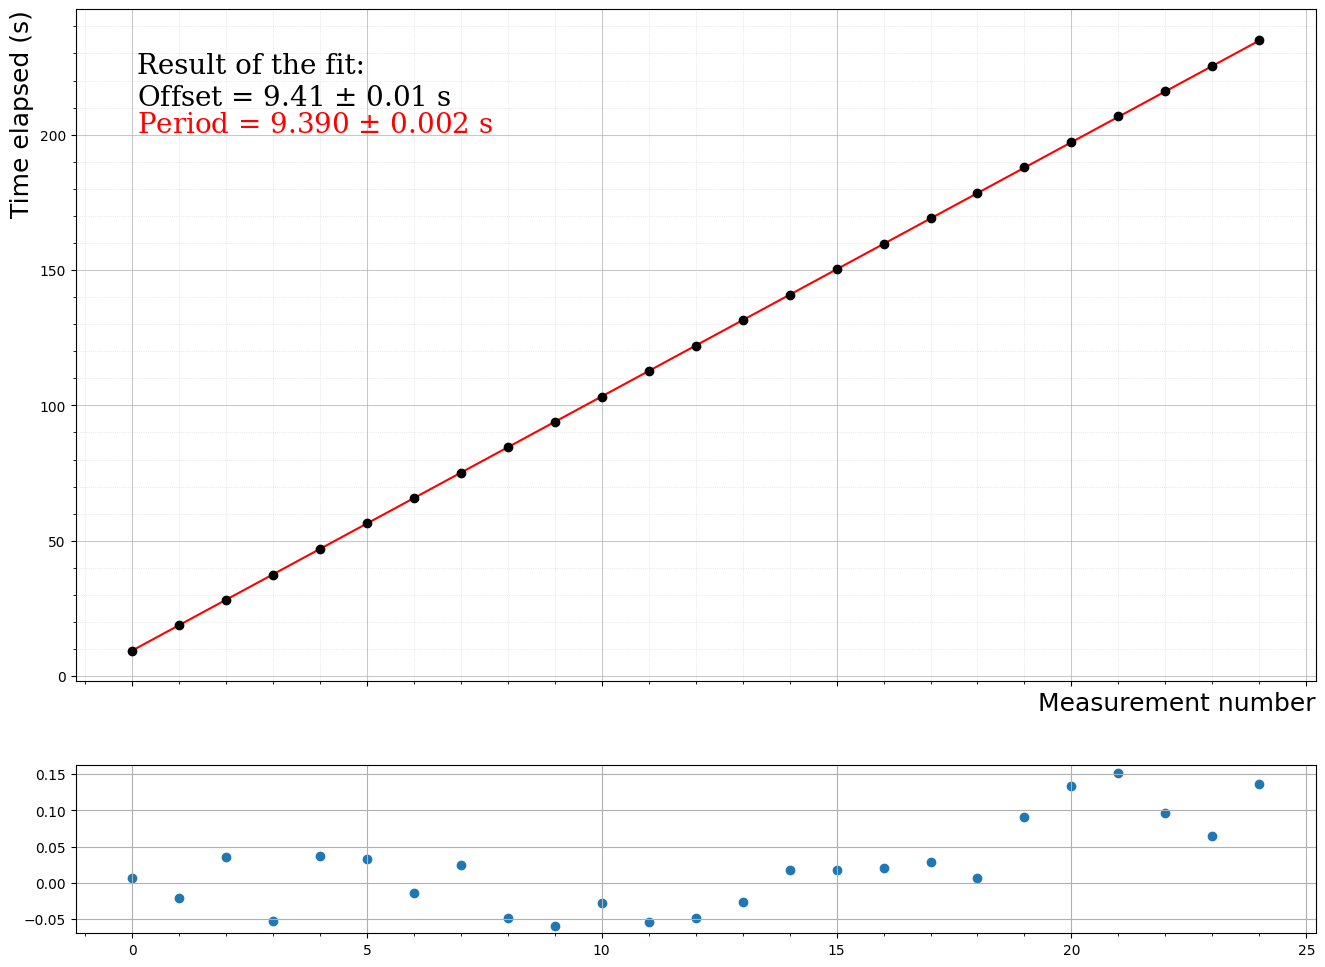

Offset:  9.405316535121894 +- 0.0144945786884106 
Period: 9.39026009813857 +- 0.0015022928848354967
18.756413962275452


In [80]:
mig1 = pd.read_csv('Miguel_1.dat', delimiter='\t', header=None)
mig2 = pd.read_csv('Miguel2.dat', delimiter='\t', header=None)
mich1 = pd.read_csv('michal_1.dat', delimiter='\t', header=None)
mich2 = pd.read_csv('michal_2_good.dat', delimiter='\t', header=None)
sara1 = pd.read_csv('Sara_trial1.dat', delimiter='\t', header=None)
sara2 = pd.read_csv('Sara_trial2.dat', delimiter='\t', header=None)

data_sets = [mig1[1], mig2[1], mich1[1], pd.concat([pd.Series([0.00]),mich2[1]], ignore_index=True), pd.concat([sara1[1].iloc[:21], sara1[1].iloc[21:].shift(1)]).reset_index(drop=True), sara2[1]]
data_sets_letter = ['mig1', 'mig2', 'mich1', 'mich2', 'sara1', 'sara2']

#substract the starting points so all data sets start at 0. aka ignore the time before the first tap
for i in range(len(data_sets)):
    data_sets[i] -= data_sets[i][0]

#creation of the averaged values of the times and the uncertainty of the mean
mean_data = np.zeros(26)
err_data = np.zeros(26)
for i in range(len(mean_data)):
    mean_data[i] = np.mean([ds[i] for ds in data_sets if pd.notna(ds[i])])
    if i == 4:
        err_data[i] = error_mean([ds[i] for ds in data_sets if pd.notna(ds[i])], 5)
    else:
        err_data[i] = error_mean([ds[i] for ds in data_sets if pd.notna(ds[i])], 6)


offset, offset_err, period, period_err, res, chi2_val = plot_fit(np.arange(0,25),mean_data[1:], err_data[1:], fit_function, [0,9])
print('Offset: ',offset, '+-',offset_err,'\nPeriod:' ,period,'+-', period_err)
print(chi2_val)


Now, when calculating the values for the length we are confronted with the fact that the measurements have an error so we have to combine statistical with measured errors. In the ocassion of the laser, we can once again use the error on the mean and the measured error (which is equal to all of the measurements).
\begin{equation}
    \sigma_{\bar x} = \sqrt{(\frac{\sigma}{\sqrt{N}})^2 + \sigma_{error}^2}
\end{equation}

In [81]:
#these are to the floor from the top of the pendulum, Miguel, Michał, Sara
laser = np.array([22.262, 22.256, 22.175, 22.157, 22.157, 22.158])
laser -= 0.01
laser_err = 0.01

#these are length floor to the bottom of the weight, Miguel, Michał and Sara
lf = np.array([0.1945, 0.195, 0.195])
lf_error = 0.0005
lf_mean, lf_mean_error = np.mean(lf), error_mean_measured(lf, 3, lf_error)
#After
lf = [0.194, 'nan', 0.1935]

#These are to the top of the weight
#first trial, first is measured at the top and the other two are what was measured at the bottom
# these are, value and error
lt1 = np.array([[21.97, 0.005], [0.05, 0.001], [0.04, 0.005]])
lt2 = np.array([[22.37, 0.02], [0.402, 0.02], [0.395, 0.02]])
lt3 = np.array([[21.972, 0.0005], [0.0496, 0.001], [0.05, 0.001]])
lt = np.array([lt1, lt2, lt3])

l_weight = np.array([0.03, 0.0005])

lt_values = np.zeros((3, 2, 2))
for i in range(3):
    lt_values[i] = ([[lt[i,0,0] - lt[i,1,0] + l_weight[0]/2, np.sqrt(lt[i,0,1]**2 + lt[i,1,1]**2 + (l_weight[1]/2)**2) ], [lt[i,0,0] - lt[i,2,0] + l_weight[0]/2, np.sqrt(lt[i,0,1]**2 + lt[i,2,1]**2 + (l_weight[1]/2)**2) ]])

laser_length, laser_mean_err = np.mean(laser), error_mean_measured(laser, len(laser), laser_err)
laser_length -= (lf_mean + l_weight[0]/2)
laser_mean_err = np.sqrt(laser_mean_err**2 + (l_weight[1]/2)**2 + lf_mean_error**2)
tape_length, tape_mean_err = weighted_mean_err(lt_values[:,:, 0 ], lt_values[:,:,1])

g_tape = tape_length * (2*np.pi / period)**2
g_tape_err = np.sqrt((tape_mean_err/tape_length)**2 + (period_err/period)**2) * g_tape
print('Tape', g_tape, '+-', g_tape_err)

g_laser = laser_length * (2*np.pi / period)**2
g_laser_err = np.sqrt((laser_mean_err/laser_length)**2 + (period_err/period)**2) * g_laser
print('Laser', g_laser, '+-', g_laser_err)


Tape 9.821732897763368 +- 0.0016110702188693936
Laser 9.838303166716022 +- 0.009706200656982786


# Second method: gaussian periods


In [82]:
sigma_times = np.zeros((6))
res = []

#Do the first fit, find the residuals, their std and recalculate the fit
meas_errt = np.full((25), 0.0001)
for i in range(6):
    data_sets[i] = data_sets[i][0:26]
    if i == 4:
        sol = find_fit(np.arange(25)[np.r_[0:21, 21+1:25]],data_sets[i][np.r_[0:21, 21+1:25]], meas_errt[1:],fit_function,[0,9])
        res.append(sol[4])
        y = fit_function(np.arange(25)[np.r_[0:21, 21+1:25]], sol[0], sol[2])

    else:
        sol = find_fit(np.arange(25),data_sets[i][1:], meas_errt, fit_function,[0,9])
        res.append(sol[4])
        y = fit_function(np.arange(25), sol[0], sol[2])

    mu, std = stats.norm.fit(sol[4])
    sigma_times[i] = std

periods2 = np.zeros(6)
periodserr2 = np.zeros(6)
for i in range(6):
    data_sets[i] = data_sets[i][0:26]
    sigmaT = np.full((25), sigma_times[i])

    if i == 4:
        offset2, offset2_err, period2, period2_err, res2, chi22 = find_fit(np.arange(25)[np.r_[0:21, 21+1:25]], data_sets[i][np.r_[0:21, 21+1:25]], sigmaT[1:],  fit_function, [0,9])

    else:
        offset2, offset2_err, period2, period2_err, res2, chi22 = find_fit(np.arange(25),data_sets[i][1:], sigmaT,  fit_function, [0,9])
    
    periods2[i] = period2
    periodserr2[i] =period2_err

period_weighted_mean , period_weighted_error_mean = weighted_mean_err(periods2, periodserr2)

g_tape = tape_length * (2*np.pi / period_weighted_mean)**2
g_tape_err = np.sqrt((tape_mean_err/tape_length)**2 + (period_weighted_error_mean/period_weighted_mean)**2) * g_tape
print('Tape', g_tape, '+-', g_tape_err)

g_laser = laser_length * (2*np.pi / period_weighted_mean)**2
g_laser_err = np.sqrt((laser_mean_err/laser_length)**2 + (period_weighted_error_mean/period_weighted_mean)**2) * g_laser
print('Laser', g_laser, '+-', g_laser_err)



Tape 9.825216357385324 +- 0.001007142595582028
Laser 9.841792503290998 +- 0.009627500786232404
